[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/trabajo-final_AA1/blob/main/notebooks_pasos_previos/00_preprocesamiento_dataset_clasificacion.ipynb)



# Preparación y preprocesamiento de datos del dataset Ninapro DB1

## Descripción corta del dataset

*Ninapro* ([link](https://ninapro.hevs.ch/)) es un base de datos publica destinada a fomentar la investigación de aprendizaje automático en manos humanas, robóticas y protésicas. *Ninapro* posee 10 datasets que incluyen 180 adquisiciones de datos de sujetos sanos y con amputacion transradial (debajo del codo). 

En este caso especifico, se seleccionó el dataset [DB1](https://ninapro.hevs.ch/instructions/DB1.html) el cual se describe brevemente en la siguiente tabla:

| Columna                     | Descripción                                                   | Ejemplo                |
|:----------------------------|:--------------------------------------------------------------|:-----------------------|
| `Subject`                   | Sujeto                                                        | 01                     |
| `Hand`                      | Mano                                                          | Intact                 |
| `Handedness`                | Lateralidad                                                   | Right / Left           |
| `Gender`                    | Genero                                                        | Male / Female          |
| `Age`                       | Edad                                                          | 31                     |
| `Height`                    | Altura                                                        | 170                    |
| `Weight`                    | Peso                                                          | 75                     |
| `zip files`                 | Archivos con las adquisición de los datos                     | s1.zip                 |

En DB1, existen 27 archivos comprimidos (`S1.zip`, `S2.zip`, ..., `S27.zip`) con la adquisición de datos de los sujetos. Cada archivo contiene un directorio con tres archivos MAT (Matlab) con el siguiente formado `Sx_Ay_Ez.mat` donde:
* **`x`**: Numero del sujeto (entre 1 y 27).
* **`y`**: Adquisición (A1: Primera adquisición).
* **`z`**: Numero del ejercicio: 1, 2 o 3.

Como nuestro trabajo solo se va a centrar en las posturas del ejercicio uno, solo nos va a interesar los archivos MAT de la forma `Sx_A1_E1.mat` de cada uno de los 27 sujetos.

## Objetivo a desarrollar

> Obtener del dataset crudo los datos, combinarlos y realizar una transformación simple para hacerlos aptos para el entrenamiento de los modelos a emplear.

## Resumen del proceso realizado

El procedimiento se resume en los siguientes pasos:
1. Combinación de los datasets del ejercicio 1 (`Sx_A1_E3.mat`) de los 27 sujetos de prueba en un unico dataset.
2. Conocimiento de la forma básica del dataset para identificar las columnas asociadas a los sensores de electromiografia, el numero de repeticiones y la postura realizada; los cuales representan los datos de interes.
3. Extracción las columnas de interes, realizar una visualización rapida de las señales y comprender el contexto de uso de estas.
4. Realición del preproceamiento de las señales adquiridas el cual se resume en:
   * **Filtrado**: Eliminar el ruido que pueda tener la señal. El filtrado se hara para toda la base de datos.
   * **Enventanado**: Tomar porciones de la señal para hacer un analisis localizado. Es importante tener en cuenta que solo se seleccionó la información asociada a los 10 primeros sujetos de los 27 que tiene la base de datos.
5. Extracción de caracteristicas sobre cada segmento de la señal (ventana) con el fin de reducir la cantidad de información para alimentar los modelos. 
6. A partir la base de datos que contiene los vectores caracteristicos de las ventanas de tiempo de la información de los 10 sujetos seleccionadas se generó un archivo CSV para las etapas siguientes del proceso de analitica de datos.

A continuación se trabaja sobre las plantillas que el profesor nos facilito durante el curso.

## 1. Librerias y configuraciones previas


In [2]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

try:
    import mlflow
    print("La librería 'mlflow' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'mlflow' no está instalada.")
    print("Instalando 'mlflow'...")
    !pip install mlflow

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.
La librería 'mlflow' está instalada y se ha importado correctamente.


In [3]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal


In [8]:
import requests
from tqdm import tqdm
import os
import zipfile
import sys

In [5]:
from libemg.data_handler import OfflineDataHandler, RegexFilter
from libemg.utils import get_windows
from libemg.feature_extractor import FeatureExtractor

## 2. Funciones

In [6]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
# from utils.funciones1 import multiple_plot
# from utils.funciones2 import test_hola, graficar_medida, graficar_medida2, filter_signal, \
#                             segmentar_data_base, aplanar_data_base, aplanar_ventana, \
#                             rms_value, mav_value, features_data_base

## 3. Carga y preprocesamiento del dataset original

Configuración inicial

In [9]:
# Agregar el directorio raíz del proyecto al PYTHONPATH
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Sube un nivel
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)
print(f"Directorio raíz del proyecto agregado al PYTHONPATH: {ROOT_DIR}")

Directorio raíz del proyecto agregado al PYTHONPATH: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia


In [13]:
# se importan las rutas
# from globals import SRC_DIR, DATA_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR
# Agregar el directorio SRC_DIR al PYTHONPATH
#if SRC_DIR not in sys.path:
#    sys.path.append(SRC_DIR)
from globals import RAW_DATA_DIR, PROCESSED_DATA_DIR
print(f"Ruta datos crudos: {RAW_DATA_DIR}")
print(f"Ruta datos procesados: {PROCESSED_DATA_DIR}")

Ruta datos crudos: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\raw
Ruta datos procesados: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\processed


### Visualización de un solo archivo MAT

Con el fin de conocer un poco lo que contiene un solo MAT vamos a realizar los siguientes procedimientos.

En nuestro analisis, solo nos va a interesar los datos de las columnas:
* **`emg`**: Señales EMG superficiales tomadas de los 10 electronos.
* **`rerepetition`**: Repetición de la postura de la mano (ejercicio) realizado. Cada postura se repetira 10 veces.
* **`restimulus`**: Postura manual (ejercicio) realizada.

### Caso de las señales EMG

Dado que los registros de la base de datos son señales (secuencias temporales), es necesario llevar a cabo una etapa adicional de **procesamiento digital de señales** con el fin de garantizar que los datos de entrada al modelo sean adecuados. En esta fase se realizan pasos clave; como la segmentación de la señal y la extracción de características mediante transformaciones. En nuestro caso se realizaron basicamente dos pasos en esta etapa:
1. Filtrado.
2. Segmentación.
3. Extracción de caracteristicas.

### Carga de datos

### Combinación de los archivos

In [15]:
NUM_SUBJECTS = 27

dataset_folder = RAW_DATA_DIR                                    # Carpeta donde están los archivos csv crudos
subjects_values = [str(i) for i in range(1, NUM_SUBJECTS + 1)]  # Lista de sujetos a filtrar (s1 a s27)
actions_values = ['1']                                           # Adquisicion 1
exercises_values = ['3']                                         # Ejercicio tipo 3 (agarres)

#### Datos EMG

**Forma**: `S{x}_A{y}_E{z}_emg.cvs`

In [21]:

# Definir los filtros RegEx para extraer metadatos del nombre de archivo
emg_filters_emg = [
    RegexFilter(left_bound = "/S", right_bound="_", values = subjects_values, description='subject'),
    RegexFilter(left_bound = "A", right_bound="_", values = actions_values, description='action'),
    RegexFilter(left_bound = "E", right_bound="_emg.csv", values = exercises_values, description='exercise')
]

emg_odh = OfflineDataHandler()
emg_odh.get_data(folder_location = dataset_folder, regex_filters = emg_filters_emg, delimiter=",")

27 data files fetched out of 216 files.


#### Datos restimulus

**Forma**: `S{x}_A{y}_E{z}_restimulus.cvs`

In [22]:
regex_filters_restimulus = [
    RegexFilter(left_bound = "/S", right_bound="_", values = subjects_values, description='subject'),
    RegexFilter(left_bound = "A", right_bound="_", values = actions_values, description='action'),
    RegexFilter(left_bound = "E", right_bound="_restimulus.csv", values = exercises_values, description='exercise')  
]

restimulus_odh = OfflineDataHandler()
restimulus_odh.get_data(folder_location = dataset_folder, regex_filters = regex_filters_restimulus, delimiter=",")

27 data files fetched out of 216 files.


#### Datos rerepetition

**Forma**: `S{x}_A{y}_E{z}_rerepetition.cvs`

In [23]:
rerepetition_regex_filters = [
    RegexFilter(left_bound = "/S", right_bound="_", values = subjects_values, description='subject'),
    RegexFilter(left_bound = "A", right_bound="_", values = actions_values, description='action'),
    RegexFilter(left_bound = "E", right_bound="_rerepetition.csv", values = exercises_values, description='exercise')   
]

rerepetition_odh = OfflineDataHandler()
rerepetition_odh.get_data(folder_location = dataset_folder, regex_filters = rerepetition_regex_filters, delimiter=",")

27 data files fetched out of 216 files.


In [36]:
len(emg_odh.isolate_data(key="subject", values=[0,1,2]).data)

3

### Obtención de los datos 

In [87]:
END_INDEX = 3
sub_index = list(range(END_INDEX))
emg_data = emg_odh.isolate_data(key="subject", values = sub_index).data
restimulus_data = restimulus_odh.isolate_data(key="subject", values = sub_index).data
rerepetition_data = rerepetition_odh.isolate_data(key="subject", values = sub_index).data

data_ex3 = []
for i in sub_index:
    # Se elimina la primera fila
    emg_data[i] = emg_data[i][1:]
    restimulus_data[i] = restimulus_data[i][1:]
    rerepetition_data[i] = rerepetition_data[i][1:]    
    # print(emg_data[i].shape, restimulus_data[i].shape, rerepetition_data[i].shape)
    print(f"Se agregan {emg_data[i].shape[0]} registros del sujeto {i} al conjunto de datos")
    data_i = X_total = np.concatenate((emg_data[i], restimulus_data[i], rerepetition_data[i]), axis=1)
    data_ex3.append(data_i)

Se agregan 227493 registros del sujeto 0 al conjunto de datos
Se agregan 229084 registros del sujeto 1 al conjunto de datos
Se agregan 224375 registros del sujeto 2 al conjunto de datos


Realicemos el muestreo de los datos asociados a un sujeto para visualizar que la carga de datos se ha realizado correctamente.

In [88]:
sub_index = 0
emg, restimulus, rerepetition = data_ex3[sub_index][:,:10], data_ex3[sub_index][:,10], data_ex3[sub_index][:,11]

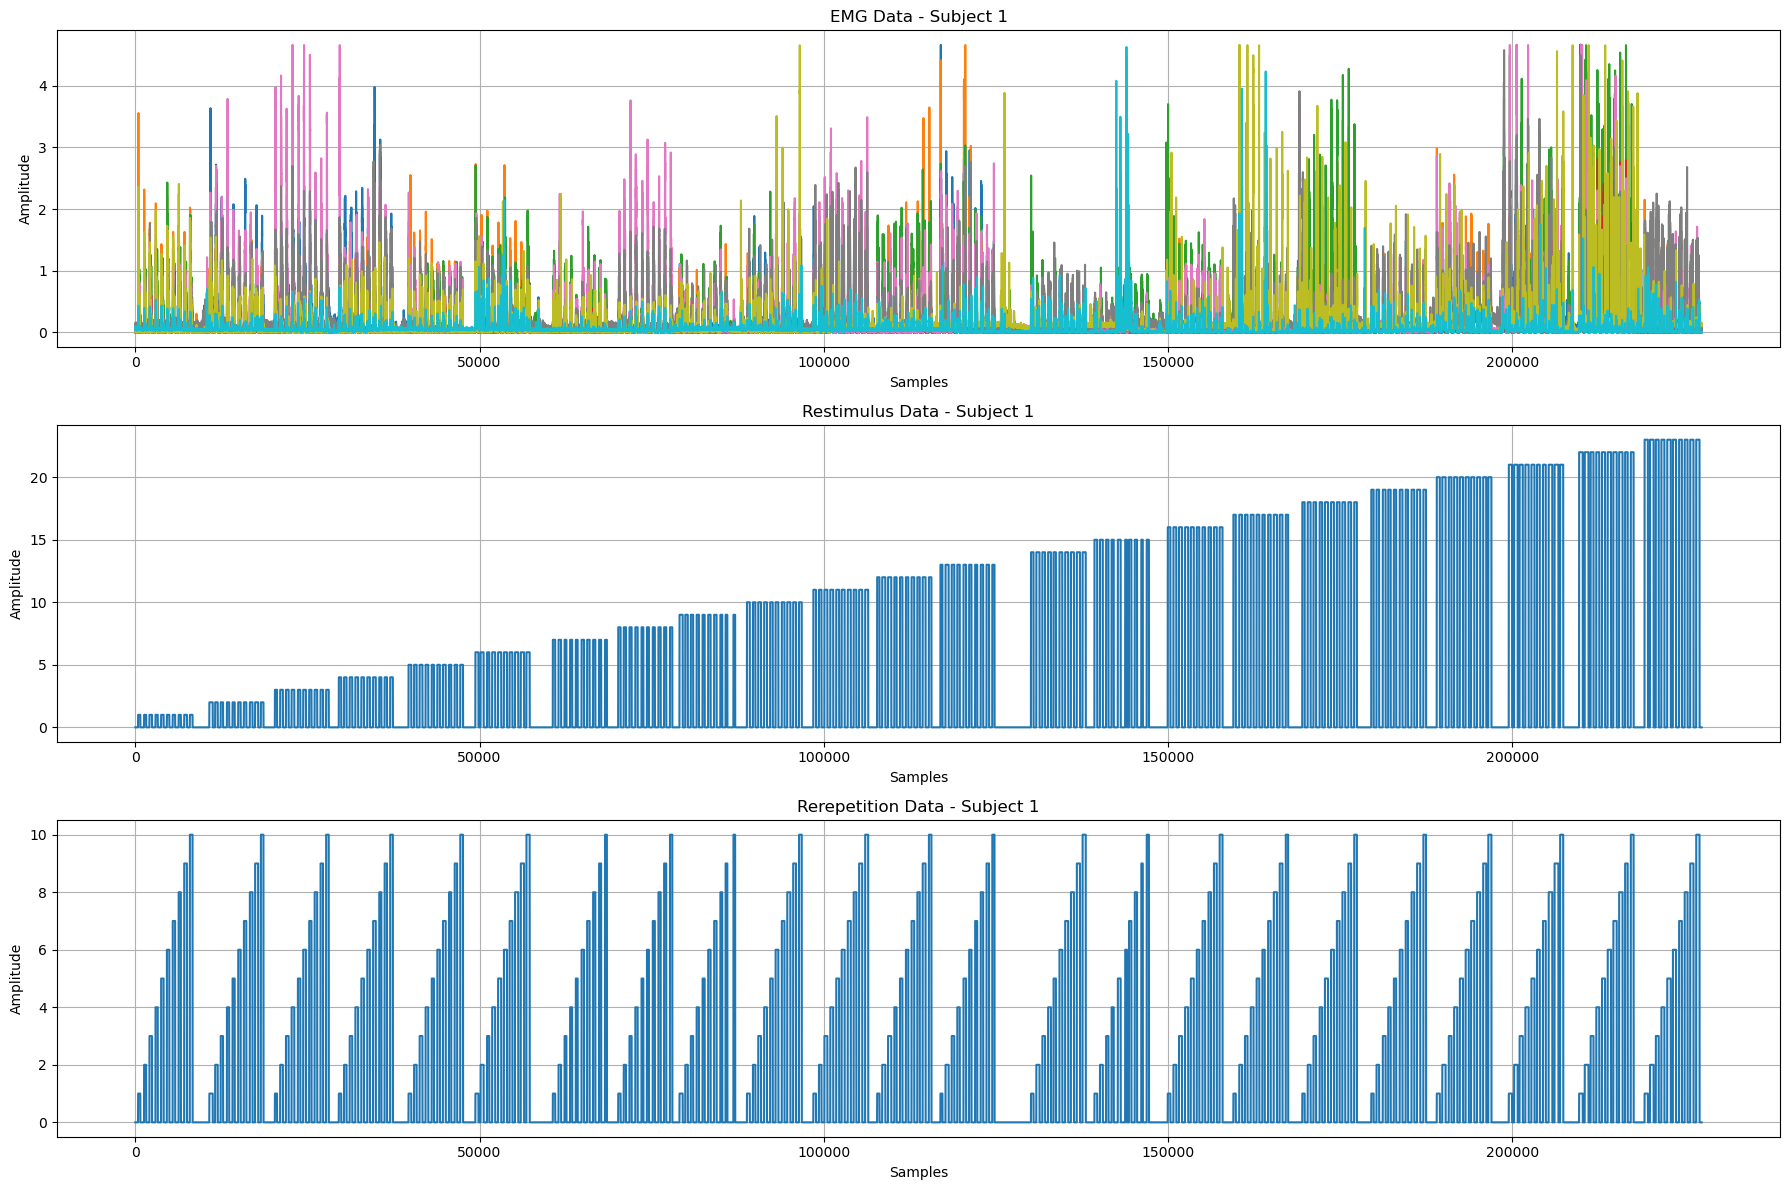

In [90]:
plt.figure(figsize=(18, 12))

# Primer subplot para emg_s1
plt.subplot(3, 1, 1)
plt.plot(emg)  # Muestra los primeros 10,000 puntos
plt.title("EMG Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# restimulus_s1
plt.subplot(3, 1, 2)
plt.plot(restimulus)  # Muestra los primeros 10,000 puntos
plt.title("Restimulus Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# rerepetition_s1
plt.subplot(3, 1, 3)
plt.plot(rerepetition)  # Muestra los primeros 10,000 puntos
plt.title("Rerepetition Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

Guardar varias matrices...

In [92]:
# Crear un directorio para guardar las matrices si no existe
output_dir = PROCESSED_DATA_DIR

# Guardar cada matriz numpy en un archivo separado
for idx, matrix in enumerate(data_ex3):
    file_path = os.path.join(output_dir, f"data_ex3_subject_{idx + 1}.npy")
    np.save(file_path, matrix)
    print(f"Matriz del sujeto {idx + 1} guardada en: {file_path}")

Matriz del sujeto 1 guardada en: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\processed\data_ex3_subject_1.npy
Matriz del sujeto 2 guardada en: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\processed\data_ex3_subject_2.npy
Matriz del sujeto 3 guardada en: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\processed\data_ex3_subject_3.npy


El primer paso consiste en combinar los archivos asociados a los 27 sujetos en uno solo. 

### Preprocesamiento de la señal

#### Filtrado

Aqui se emple el filtro Butterworth pasabajas de 100 Hz sobre todos los datos.

In [35]:
# perform 2-order 1Hz low-pass filter
emgs_df_filt =  filter_signal(data_base.iloc[:,1:11])  
data_base_filter =  pd.concat([data_base['s'], emgs_df_filt, data_base['rep'] , data_base['label']], axis=1)
data_base_filter.head()

,s,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,rep,label
0,1,0.067523,0.002402,0.002399,0.002403,0.002395,0.009800,0.0024,0.050357,0.0024,0.034192,0,0
1,1,0.066284,0.002402,0.002402,0.002404,0.002395,0.009474,0.0024,0.049707,0.0024,0.032820,0,0
2,1,0.065045,0.002403,0.002405,0.002404,0.002395,0.009149,0.0024,0.049050,0.0024,0.031452,0,0
3,1,0.063810,0.002403,0.002409,0.002405,0.002395,0.008827,0.0024,0.048390,0.0024,0.030091,0,0
4,1,0.062581,0.002404,0.002412,0.002406,0.002395,0.008507,0.0024,0.047726,0.0024,0.028743,0,0


#### Segmentacion

Se seleccionan los datos de los 10 primeros sujetos del dataser y se segmentan estos en ventanas de 30 muestras de tamaño con un sobrelapamiento de 10 muestras.

In [37]:
numero_de_sujetos = 10
sujetos_muestra = data_base_filter[data_base_filter['s'] <= numero_de_sujetos]
segments = segmentar_data_base(sujetos_muestra, 30, 10)

46925


In [39]:
# Visualizacion del primer segmento
segments[0]

,s,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,rep,label
0,1,0.067523,0.002402,0.002399,0.002403,0.002395,0.009800,0.0024,0.050357,0.0024,0.034192,0,0
1,1,0.066284,0.002402,0.002402,0.002404,0.002395,0.009474,0.0024,0.049707,0.0024,0.032820,0,0
2,1,0.065045,0.002403,0.002405,0.002404,0.002395,0.009149,0.0024,0.049050,0.0024,0.031452,0,0
3,1,0.063810,0.002403,0.002409,0.002405,0.002395,0.008827,0.0024,0.048390,0.0024,0.030091,0,0
4,1,0.062581,0.002404,0.002412,0.002406,0.002395,0.008507,0.0024,0.047726,0.0024,0.028743,0,0
5,1,0.061362,0.002404,0.002415,0.002407,0.002395,0.008192,0.0024,0.047061,0.0024,0.027410,0,0
6,1,0.060156,0.002405,0.002419,0.002407,0.002396,0.007881,0.0024,0.046395,0.0024,0.026096,0,0
7,1,0.058966,0.002406,0.002422,0.002408,0.002396,0.007576,0.0024,0.045729,0.0024,0.024805,0,0
8,1,0.057793,0.002406,0.002425,0.002409,0.002396,0.007278,0.0024,0.045064,0.0024,0.023539,0,0
9,1,0.056641,0.002407,0.002428,0.002410,0.002396,0.006986,0.0024,0.044399,0.0024,0.022300,0,0


#### Extracción de caracteristicas

Por ahora solo se va a obtener el valor rms para cada una se las señales emg presentes por ventana. Para dar una perspectiva del procedimiento, se va a mostrar el resultado aplicado a la primera ventana el cual contiene el valor RMS por señal EMG (de un total de 10).

In [42]:
# RMS ventana 0
rms_seg = rms_value(segments[0].iloc[:,1:-2])
rms_seg

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10
0,0.05251,0.002414,0.002445,0.002417,0.0024,0.006204,0.0024,0.041218,0.0024,0.019526


Para el caso, una vez aplicada la entrada, cada muestra de la base de datos de entrada, tendra la siguiente forma:

In [43]:
rms_window = pd.DataFrame({'s': [segments[0].iloc[0,0]]})
rms_window = pd.concat([rms_window,rms_seg],axis=1)
rms_window['rep'] = segments[0].iloc[0,-2]
rms_window['label'] = segments[0].iloc[0,-1]
rms_window

,s,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,rep,label
0,1,0.05251,0.002414,0.002445,0.002417,0.0024,0.006204,0.0024,0.041218,0.0024,0.019526,0,0


Ahora, teniendo esto claro vamos a proceder a realizar el procediminto completo para la base de datos completa.

In [44]:
rms_val_db = features_data_base(segments)

In [46]:
rms_val_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46925 entries, 0 to 46924
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s       46925 non-null  int8   
 1   emg_1   46925 non-null  float64
 2   emg_2   46925 non-null  float64
 3   emg_3   46925 non-null  float64
 4   emg_4   46925 non-null  float64
 5   emg_5   46925 non-null  float64
 6   emg_6   46925 non-null  float64
 7   emg_7   46925 non-null  float64
 8   emg_8   46925 non-null  float64
 9   emg_9   46925 non-null  float64
 10  emg_10  46925 non-null  float64
 11  rep     46925 non-null  uint8  
 12  label   46925 non-null  uint8  
dtypes: float64(10), int8(1), uint8(2)
memory usage: 3.7 MB


In [47]:
rms_val_db.sample(20)

,s,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,rep,label
17163,4,0.025804,0.002403,0.033667,0.002528,0.002563,0.021439,0.357446,0.131232,0.002520,0.045694,10,8
28543,7,0.003136,0.263993,0.002647,0.002449,0.003737,0.178200,0.580862,0.304469,0.002438,0.212539,0,0
34476,8,0.010534,0.002366,0.002588,0.002407,0.002575,0.002399,0.010092,0.130682,0.002407,0.092121,0,0
25257,6,0.003827,0.006357,0.004866,0.001463,0.007224,0.073094,1.012269,0.412091,0.010257,0.557668,0,0
26833,6,0.003159,0.117810,0.739329,0.197331,0.011000,0.018226,0.146385,0.167865,0.065650,0.158774,7,9
15377,4,0.023568,0.002399,0.002695,0.002412,0.002490,0.002811,0.064824,0.037740,0.002395,0.007087,0,0
46382,10,0.002955,0.421433,0.662003,0.367929,0.086551,0.147225,0.904262,1.227963,0.642362,0.660980,7,11
10939,3,0.005620,0.002434,0.002580,0.004142,0.002667,0.002404,0.126299,0.172211,0.023134,0.012115,0,0
36854,8,0.025676,0.017268,0.035936,0.002656,0.002661,0.003499,0.013442,0.084714,0.005638,0.035654,3,11
10190,3,0.016281,0.419931,0.024641,0.002423,0.002509,0.002483,0.289725,0.194569,0.002429,0.002431,1,3


## 4. Exportar el dataset estructurado

In [49]:
# Exportamos el dataframe a un archivo CSV
rms_val_db.to_csv('./datasets_tarea/db1_rms_features.csv', index=False)

## Conclusiones

Al finalizar este notebook se logro.
* Comprender el contexto del problema mediante la visualización las señales EMG de la base de datos.
* Combinar los diferentes datasetets en uno solo.
* Realizar un preprocesamiento basico de las señales adquiridas.
* Seleccionar una porcion de la base de datos suficiente, transformarla y almacenarla en una base de datos mas sencilla para las posteriores tareas de aprendizaje de maquina.

### Referencias


- *Dataset:*  
    - https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho?select=car+details+v4.csv
    
    
- *Machine learning con Python y Scikit-learn:*
    - https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html
    
    
- *LocalOutlierFactor:*
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
    

- *scikit-learn:*    
    - https://scikit-learn.org/stable/
    - https://scikit-learn.org/stable/user_guide.html
  
  
- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180

  